In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle
from postgres.config import SessionLocal
from postgres.models import AdvancedPlayerStats, ClusteredPlayers





In [3]:
session = SessionLocal()

players = session.query(AdvancedPlayerStats).all()
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {column.name: getattr(player, column.name) for column in player.__table__.columns}
    data.append(player_dict)

df = pd.DataFrame(data)

df.set_index('PLAYER', inplace=True)


df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['id', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
# df = df.astype(float)
df.head()

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
jalen wilson,24,26.9,107.2,115.3,-8.1,9.7,1.54,14.8,3.7,9.5,...,22.4,115.3,9.5,12.1,2.3,11.5,6.7,9.0,26.0,0.050
nicolas batum,36,17.7,106.5,101.9,4.6,10.5,2.95,29.1,3.7,11.4,...,8.9,101.9,11.4,18.9,23.7,6.4,4.7,5.1,15.9,0.104
julian strawther,22,22.1,112.2,114.3,-2.1,8.7,1.71,13.3,1.3,8.0,...,20.5,114.3,8.0,16.8,12.6,8.8,7.0,8.1,22.8,0.048
michael porter jr.,26,33.3,120.7,112.6,8.1,9.3,1.75,12.9,4.8,13.8,...,16.5,112.6,13.8,10.9,14.1,12.0,9.7,12.3,36.1,0.088
alperen sengun,22,31.3,114.7,106.5,8.2,25.1,2.05,19.9,9.9,21.5,...,53.3,106.5,21.5,23.2,27.5,9.7,8.5,8.7,31.0,0.138


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [4]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,jalen wilson,24,26.9,107.2,115.3,-8.1,9.7,1.54,14.8,3.7,...,22.4,115.3,9.5,12.1,2.3,11.5,6.7,9.0,26.0,0.050
1,nicolas batum,36,17.7,106.5,101.9,4.6,10.5,2.95,29.1,3.7,...,8.9,101.9,11.4,18.9,23.7,6.4,4.7,5.1,15.9,0.104
2,julian strawther,22,22.1,112.2,114.3,-2.1,8.7,1.71,13.3,1.3,...,20.5,114.3,8.0,16.8,12.6,8.8,7.0,8.1,22.8,0.048
3,michael porter jr.,26,33.3,120.7,112.6,8.1,9.3,1.75,12.9,4.8,...,16.5,112.6,13.8,10.9,14.1,12.0,9.7,12.3,36.1,0.088
4,alperen sengun,22,31.3,114.7,106.5,8.2,25.1,2.05,19.9,9.9,...,53.3,106.5,21.5,23.2,27.5,9.7,8.5,8.7,31.0,0.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,day'ron sharpe,23,17.2,108.8,110.5,-1.8,13.0,1.23,14.7,14.7,...,43.3,110.5,20.6,26.9,34.4,7.6,5.0,5.3,15.2,0.056
311,micah potter,26,17.3,106.6,108.9,-2.4,6.3,1.30,17.6,5.9,...,10.5,108.9,14.7,8.3,21.4,4.9,5.3,6.6,16.1,0.063
312,tosan evbuomwan,23,23.5,102.5,110.0,-7.4,9.2,0.76,11.5,4.7,...,26.3,110.0,14.5,13.8,21.1,9.9,4.7,8.3,23.4,0.079
313,justin edwards,21,19.2,111.3,118.4,-7.0,7.4,1.08,13.0,3.3,...,28.6,118.4,11.2,13.2,15.0,7.3,5.7,6.5,21.7,0.019


In [5]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [6]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.42818225714184543
Variance with 3 components: 0.5327377881697368
Variance with 4 components: 0.6326577480337977
Variance with 5 components: 0.687083350186678
Variance with 6 components: 0.7318273691972856
Variance with 7 components: 0.7673300063929982
Variance with 8 components: 0.79798113855494
Variance with 9 components: 0.822948298186332
Variance with 10 components: 0.8470147787380542
Variance with 11 components: 0.867703336326
Variance with 12 components: 0.8877007902288699
Variance with 13 components: 0.9038498252976868
Variance with 14 components: 0.9189599234602317
Variance with 15 components: 0.9330276984083842
Variance with 16 components: 0.9448507597325271
Variance with 17 components: 0.9551161076671743
Variance with 18 components: 0.9641881922545189
Variance with 19 components: 0.9716589286062947
Variance with 20 components: 0.9783136020873735
Variance with 21 components: 0.9836411102942547
Variance with 22 components: 0.9876485561055303
Varianc

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

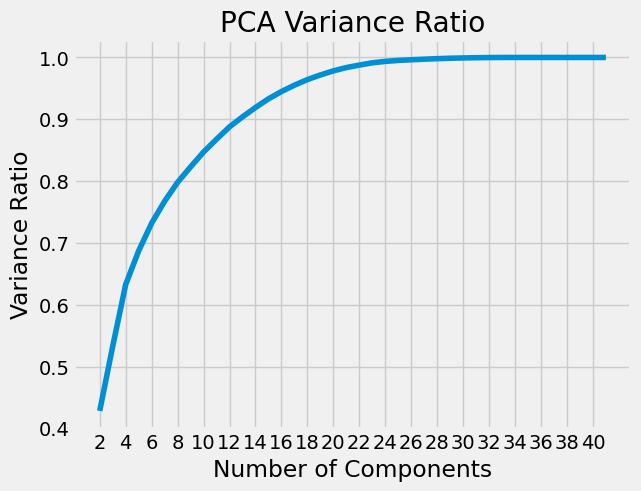

In [7]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [8]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.04555531e-01 9.99199599e-02 5.44256022e-02 4.47440190e-02
 3.55026372e-02 3.06511322e-02 2.49671596e-02 2.40664806e-02
 2.06885576e-02 1.99974539e-02 1.61490351e-02 1.51100982e-02
 1.40677749e-02 1.18230613e-02 1.02653479e-02 9.07208459e-03
 7.47073635e-03 6.65467348e-03 5.32750821e-03 4.00744581e-03
 3.67916364e-03 2.29782666e-03 1.60148152e-03 1.04301089e-03
 9.26247225e-04 8.31905375e-04 7.07413127e-04 4.70241941e-04
 3.83104153e-04 2.81198768e-04 1.10189393e-04 1.89657885e-05
 6.11429418e-07 7.73962491e-08 4.57959659e-09 1.16553511e-09
 8.41068548e-10 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

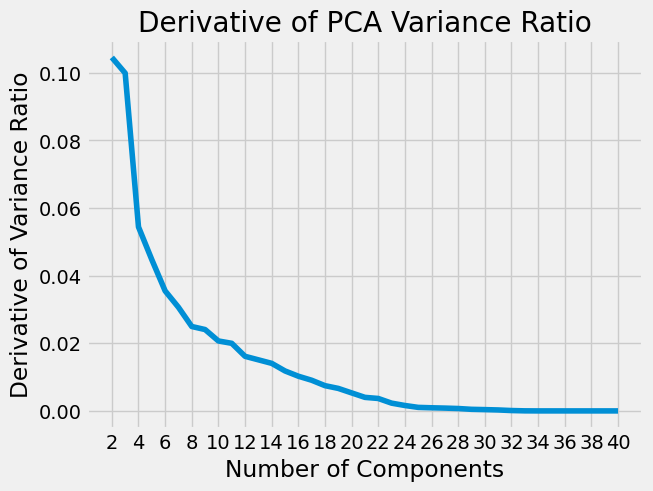

In [9]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [10]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.21774442 0.21043784 0.10455553 0.09991996 0.0544256  0.04474402
 0.03550264 0.03065113 0.02496716 0.02406648 0.02068856 0.01999745
 0.01614904 0.0151101  0.01406777 0.01182306]
0.9448507597325271


In [11]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.20940393820310418
Silhouette Score with 3 clusters: 0.18751273926957335
Silhouette Score with 4 clusters: 0.13524507075571893
Silhouette Score with 5 clusters: 0.13000652834580323
Silhouette Score with 6 clusters: 0.12186463323037013
Silhouette Score with 7 clusters: 0.11546251210211815
Silhouette Score with 8 clusters: 0.11287852371712166
Silhouette Score with 9 clusters: 0.10225448975590457
Silhouette Score with 10 clusters: 0.09561564368145986
Silhouette Score with 11 clusters: 0.09917180341863845
Silhouette Score with 12 clusters: 0.0980807825935521
Silhouette Score with 13 clusters: 0.0912026040739365
Silhouette Score with 14 clusters: 0.09179857854952432
Silhouette Score with 15 clusters: 0.08941577173271713
Silhouette Score with 16 clusters: 0.0935162239362011
Silhouette Score with 17 clusters: 0.08854959029217259
Silhouette Score with 18 clusters: 0.08614262068710395
Silhouette Score with 19 clusters: 0.08208856849230546


Silhouette Score with 20 clusters: 0.08486663579917594
Silhouette Score with 21 clusters: 0.07723349071334104
Silhouette Score with 22 clusters: 0.07341151993159796
Silhouette Score with 23 clusters: 0.07483731859190916
Silhouette Score with 24 clusters: 0.07930764467701044
Silhouette Score with 25 clusters: 0.07561239288460567
Silhouette Score with 26 clusters: 0.08114859690574884
Silhouette Score with 27 clusters: 0.08045442784738467
Silhouette Score with 28 clusters: 0.07702925686426662
Silhouette Score with 29 clusters: 0.0749029206155403
Silhouette Score with 30 clusters: 0.07772847624473478
Silhouette Score with 31 clusters: 0.06985221786400707


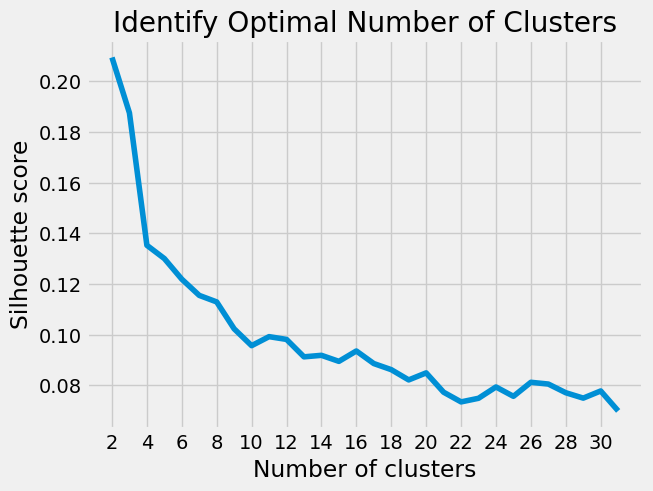

In [12]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [13]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = -0.02768948644112368
for n_cluseter = 4, improvement = -0.06433044681447164
for n_cluseter = 5, improvement = -0.0060578346913775505
for n_cluseter = 6, improvement = -0.00935857035795018
for n_cluseter = 7, improvement = -0.007290585677927286
for n_cluseter = 8, improvement = -0.002921287588542265
for n_cluseter = 9, improvement = -0.011975850258673537
for n_cluseter = 10, improvement = -0.007395020079398185
for n_cluseter = 11, improvement = 0.003932133182460662
for n_cluseter = 12, improvement = -0.001211130856279441
for n_cluseter = 13, improvement = -0.007626158071444955
for n_cluseter = 14, improvement = 0.0006557836523953808
for n_cluseter = 15, improvement = -0.002623654577639467
for n_cluseter = 16, improvement = 0.0045031004010321896
for n_cluseter = 17, improvement = -0.005479009967056525
for n_cluseter = 18, improvement = -0.002640812467065823
for n_cluseter = 19, improvement = -0.004436197908525452
for n_cluseter = 20, improvement = 0.0030

C:\conda_tmp\ipykernel_28756\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


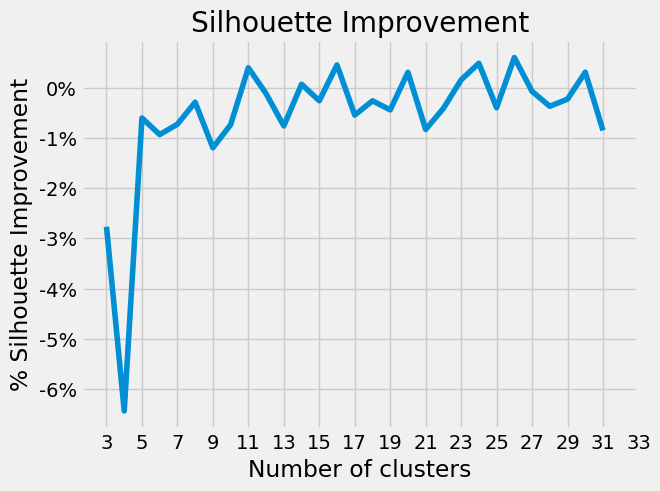

In [14]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [15]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,jalen wilson,1
1,nicolas batum,5
2,julian strawther,1
3,michael porter jr.,8
4,alperen sengun,12


In [17]:
df_cluster.columns = df_cluster.columns.str.upper()
for _, row in df_cluster.iterrows():
    existing_player = session.query(ClusteredPlayers).filter_by(PLAYER=row['PLAYER']).first()
    if existing_player:
        # Update the cluster value if the player exists
        existing_player.CLUSTER = row['CLUSTER']
    else:
        # Convert the row to a dictionary and pass it to the model
        clustered_player = ClusteredPlayers(
            PLAYER=row['PLAYER'],
            CLUSTER=row['CLUSTER']
        )
        session.add(clustered_player)
session.commit()

session.close()